In [1]:
from pathlib import Path

model_name, ds_name = "resnet18", "cifar10"
path = Path("out") / "hdsvc" / model_name / ds_name

In [3]:
import pandas as pd

metrics = pd.read_csv(
    path / "model" / "csv_logs" / model_name / "version_0" / "metrics.csv"
)
metrics.drop(columns=["train/loss"], inplace=True)
metrics = metrics.groupby("epoch").tail(1)
metrics.reset_index(inplace=True, drop=True)

best_epoch = metrics["val/loss"].argmin()
print("Best epoch:", best_epoch)

metrics  # .style.highlight_min(subset="val/loss", axis=0)

Best epoch: 6


,epoch,step,val/loss,val/acc
0,0,156,1.865393,0.379938
1,1,313,1.119740,0.610561
2,2,470,1.162722,0.604460
3,3,627,1.341312,0.556756
4,4,784,1.142220,0.630363
5,5,941,1.202129,0.634163
6,6,1098,1.054354,0.683568
7,7,1255,1.077665,0.684869
8,8,1412,1.057593,0.700970
9,9,1569,1.232068,0.683868


In [4]:
from glob import glob

from nlnas import TorchvisionClassifier

ckpt_path = (
    path / "model" / "tb_logs" / model_name / "version_0" / "checkpoints"
)
p = glob(str(ckpt_path / f"epoch={best_epoch}*.ckpt"))
assert len(p) == 1

model = TorchvisionClassifier.load_from_checkpoint(p[0])

/home/cedric/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
from nlnas.tv_dataset import TorchvisionDataset
from nlnas.utils import get_first_n

ds = TorchvisionDataset(ds_name)
ds.setup("fit")
x_train, y_train = get_first_n(ds.train_dataloader(), 5000)
x_val, y_val = get_first_n(ds.val_dataloader(), 5000)

In [11]:
import turbo_broccoli as tb

eval_train = tb.load_json(path / str(best_epoch) / "eval" / "eval.json")

eval_val = {}
model.forward_intermediate(x_val, list(eval_train.keys()), eval_val)

In [12]:
from sklearn.svm import SVC

n_classes = 10
svcs = {}
for k, e in eval_train.items():
    svcs[k] = []
    for i in range(n_classes):
        print("Outputs of submodule", k, "| class", i, "vs. rest")
        y_train_i = (y_train == i).long()
        svc = SVC().fit(e.reshape(len(e), -1), y_train_i)
        svcs[k].append(svc)

Outputs of submodule model.0.maxpool | class 0 vs. rest
Outputs of submodule model.0.maxpool | class 1 vs. rest
Outputs of submodule model.0.maxpool | class 2 vs. rest
Outputs of submodule model.0.maxpool | class 3 vs. rest
Outputs of submodule model.0.maxpool | class 4 vs. rest
Outputs of submodule model.0.maxpool | class 5 vs. rest
Outputs of submodule model.0.maxpool | class 6 vs. rest


In [77]:
import pandas as pd
from sklearn.metrics import f1_score

data = []
for k, v in svcs.items():
    for i, svc in enumerate(v):
        print(k, "|", i, "vs. rest")
        u_train = eval_train[k]
        u_train = u_train.reshape(len(u_train), -1)
        v_train = (y_train == i).long()
        s_train = f1_score(v_train, svc.predict(u_train))

        u_val = eval_val[k]
        u_val = u_val.reshape(len(u_val), -1)
        v_val = (y_val == i).long()
        s_val = f1_score(v_val, svc.predict(u_val))

        data.append([k, i, s_train, s_val])

model.0.maxpool | 0 vs. rest | train
model.0.maxpool | 0 vs. rest | val
model.0.maxpool | 1 vs. rest | train
model.0.maxpool | 1 vs. rest | val
model.0.maxpool | 2 vs. rest | train
model.0.maxpool | 2 vs. rest | val
model.0.maxpool | 3 vs. rest | train
model.0.maxpool | 3 vs. rest | val
model.0.maxpool | 4 vs. rest | train
model.0.maxpool | 4 vs. rest | val
model.0.maxpool | 5 vs. rest | train
model.0.maxpool | 5 vs. rest | val
model.0.maxpool | 6 vs. rest | train
model.0.maxpool | 6 vs. rest | val
model.0.maxpool | 7 vs. rest | train
model.0.maxpool | 7 vs. rest | val
model.0.maxpool | 8 vs. rest | train
model.0.maxpool | 8 vs. rest | val
model.0.maxpool | 9 vs. rest | train
model.0.maxpool | 9 vs. rest | val
model.0.layer1 | 0 vs. rest | train
model.0.layer1 | 0 vs. rest | val
model.0.layer1 | 1 vs. rest | train
model.0.layer1 | 1 vs. rest | val
model.0.layer1 | 2 vs. rest | train
model.0.layer1 | 2 vs. rest | val
model.0.layer1 | 3 vs. rest | train
model.0.layer1 | 3 vs. rest | val


In [78]:
df_ova = pd.DataFrame(data, columns=["submodule", "class", "train", "val"])
df_ova = df_ova.melt(
    id_vars=["submodule", "class"], var_name="dataset", value_name="f1"
)

In [ ]:
figure = sns.barplot(df_ova, x="submodule", y="f1", hue="class")
figure.set_xticklabels(
    figure.get_xticklabels(),
    rotation=45,
    rotation_mode="anchor",
    ha="right",
)

/tmp/ipykernel_2280969/3972972364.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


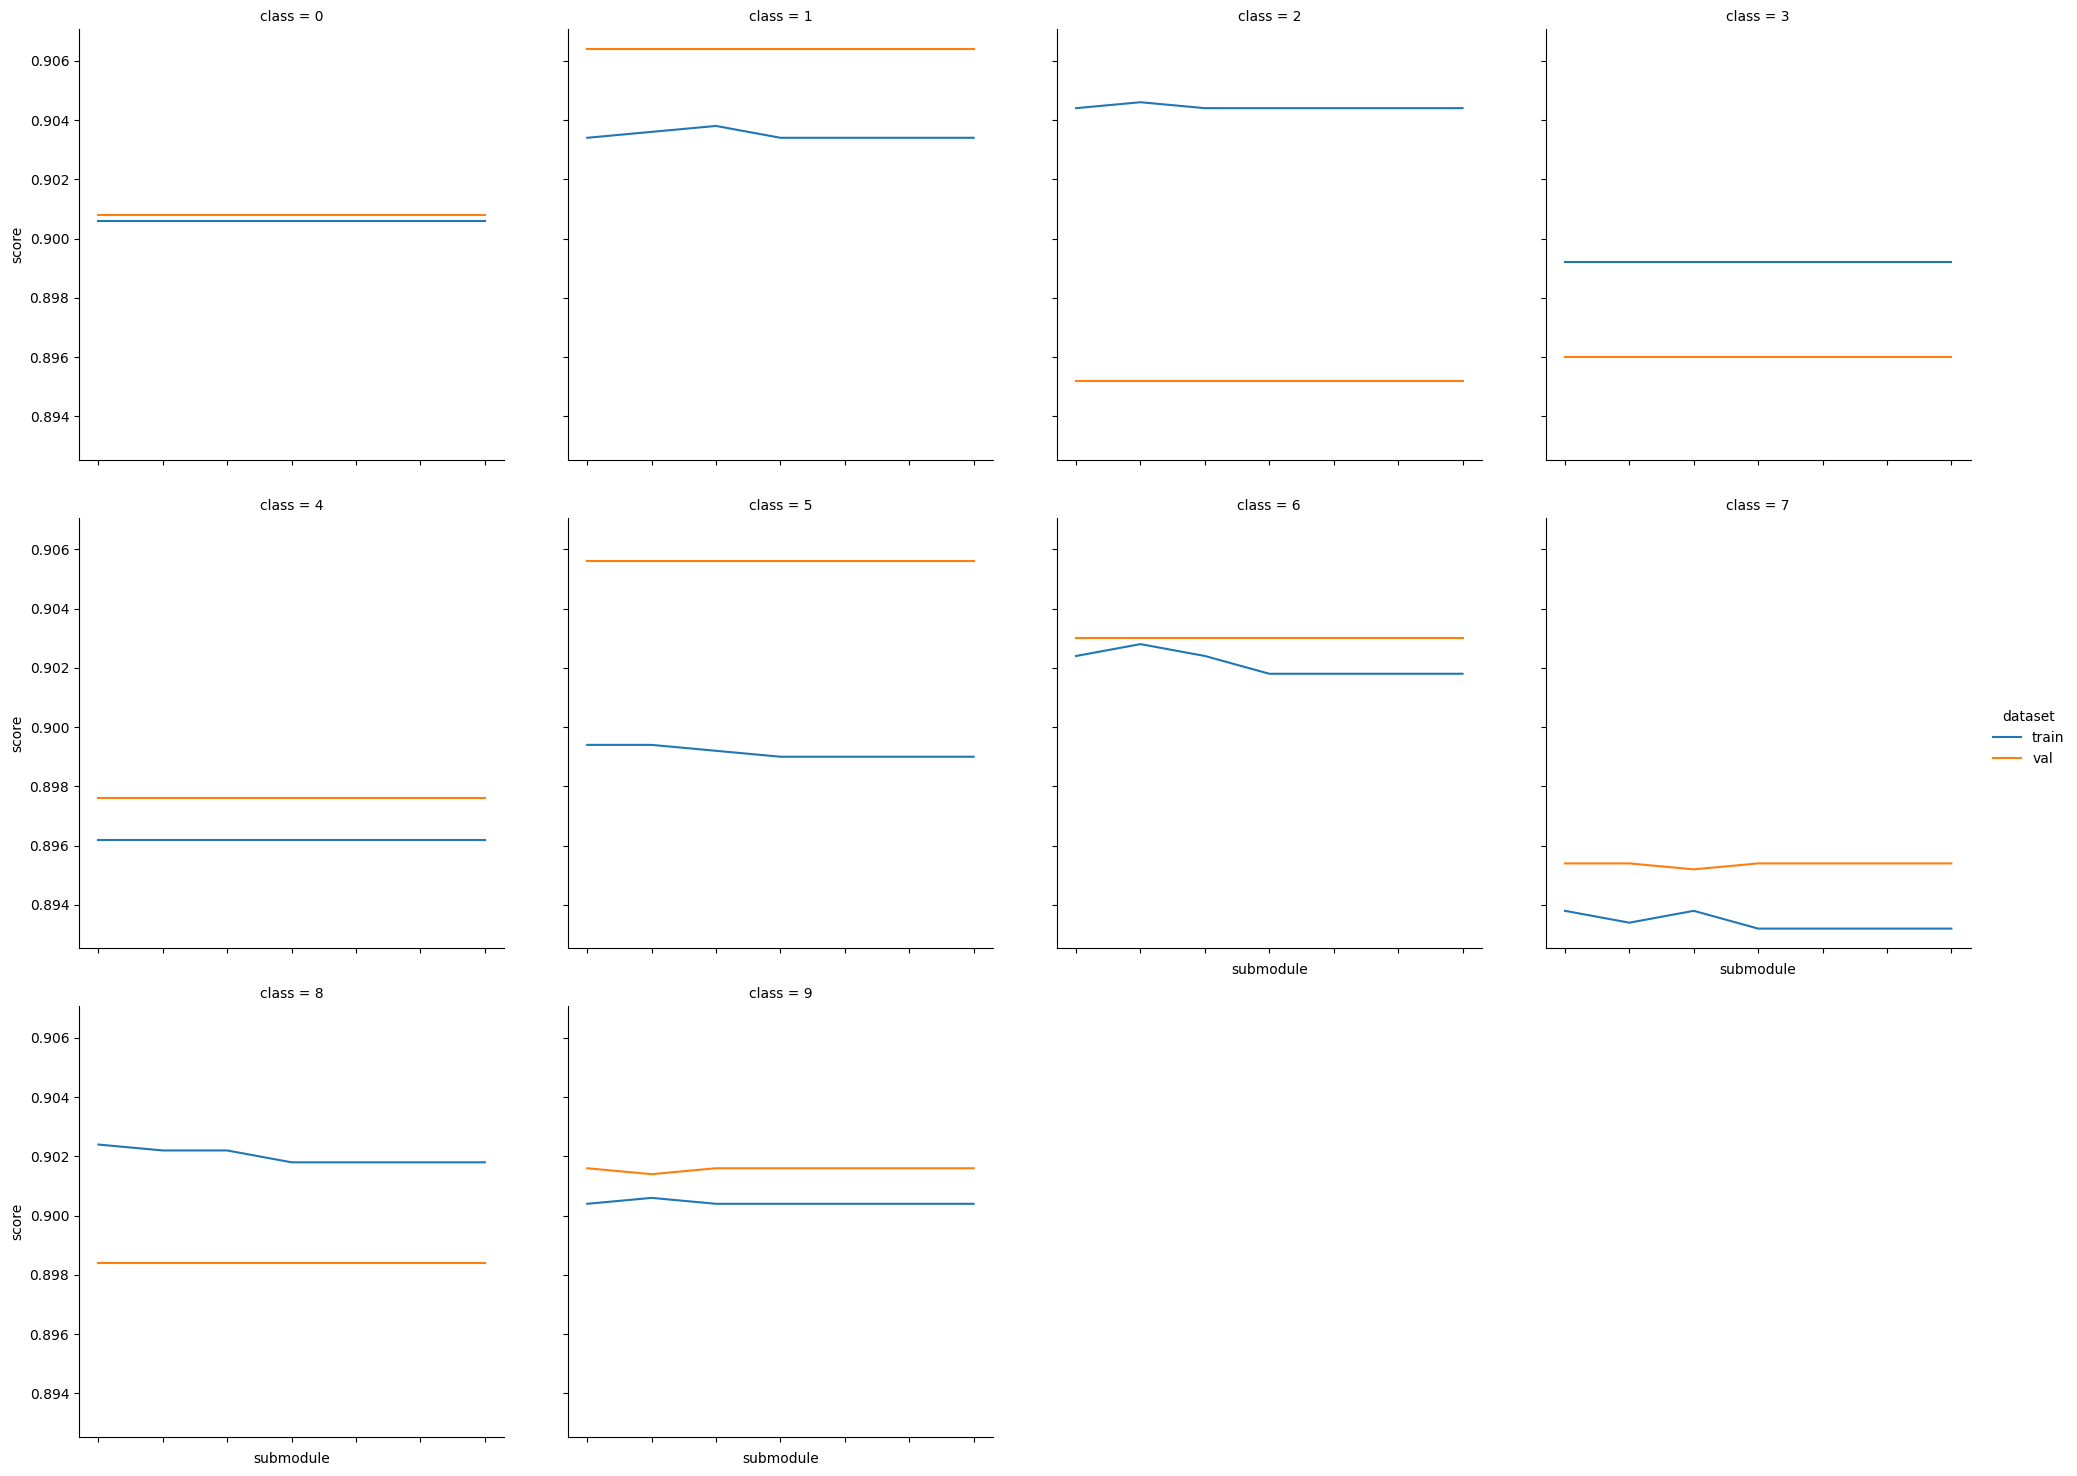

In [89]:
figure = sns.relplot(
    df_ova,
    x="submodule",
    y="f1",
    hue="dataset",
    col="class",
    kind="line",
    col_wrap=4,
)
# figure.set(title="Linear eparability score")
for ax in figure.axes_dict.values():
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        rotation_mode="anchor",
        ha="right",
    )

In [6]:
from sklearn.svm import SVC

n_classes = 10
svcs = []
for i in range(n_classes):
    print("Inputs | class", i, "vs. rest")
    y_train_i = (y_train == i).long()
    svc = SVC(kernel="rbf").fit(x_train.flatten(1), y_train_i)
    svcs.append(svc)

Inputs | class 0 vs. rest
Inputs | class 1 vs. rest
Inputs | class 2 vs. rest
Inputs | class 3 vs. rest
Inputs | class 4 vs. rest
Inputs | class 5 vs. rest
Inputs | class 6 vs. rest
Inputs | class 7 vs. rest
Inputs | class 8 vs. rest
Inputs | class 9 vs. rest


In [7]:
from sklearn.metrics import f1_score

data = [
    [
        i,
        f1_score((y_train == i).long(), svc.predict(x_train.flatten(1))),
        f1_score((y_val == i).long(), svc.predict(x_val.flatten(1))),
    ]
    for i, svc in enumerate(svcs)
]

In [8]:
import pandas as pd

df_in = pd.DataFrame(data, columns=["class", "train", "val"])
df_in = df_in.melt(id_vars="class", var_name="dataset", value_name="f1")
df_in

,class,dataset,f1
0,0,train,0.535135
1,1,train,0.634349
2,2,train,0.049149
3,3,train,0.101365
4,4,train,0.018797
5,5,train,0.267857
6,6,train,0.108949
7,7,train,0.497765
8,8,train,0.627717
9,9,train,0.539730


<Axes: xlabel='class', ylabel='f1'>

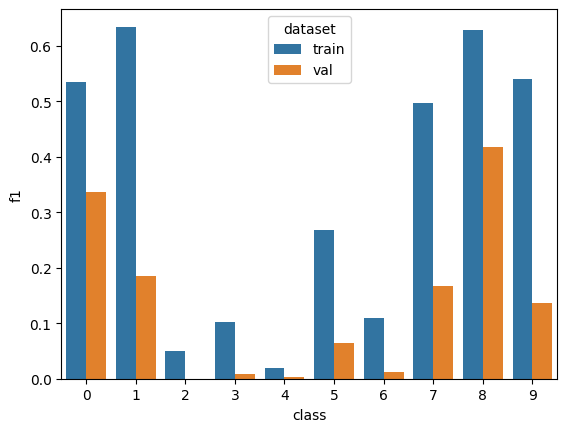

In [9]:
import seaborn as sns

sns.barplot(df_in, x="class", y="f1", hue="dataset")

In [12]:
svc = SVC().fit(x_train.flatten(1), y_train)

In [13]:
svc.score(x_train.flatten(1), y_train), svc.score(x_val.flatten(1), y_val)

(0.7164, 0.4398)